In [1]:
import torch
import cartopy.crs as ccrs
from matplotlib import pyplot as plt
from matplotlib import rc
import numpy as np
import xarray as xr

rc("font", **{"family": "Times"})
rc("text", usetex=True)
# plt.rcParams['figure.dpi']= 300
plt.rcParams['figure.dpi']= 150

samples = torch.load("samples.pt", map_location=torch.device('cpu'))

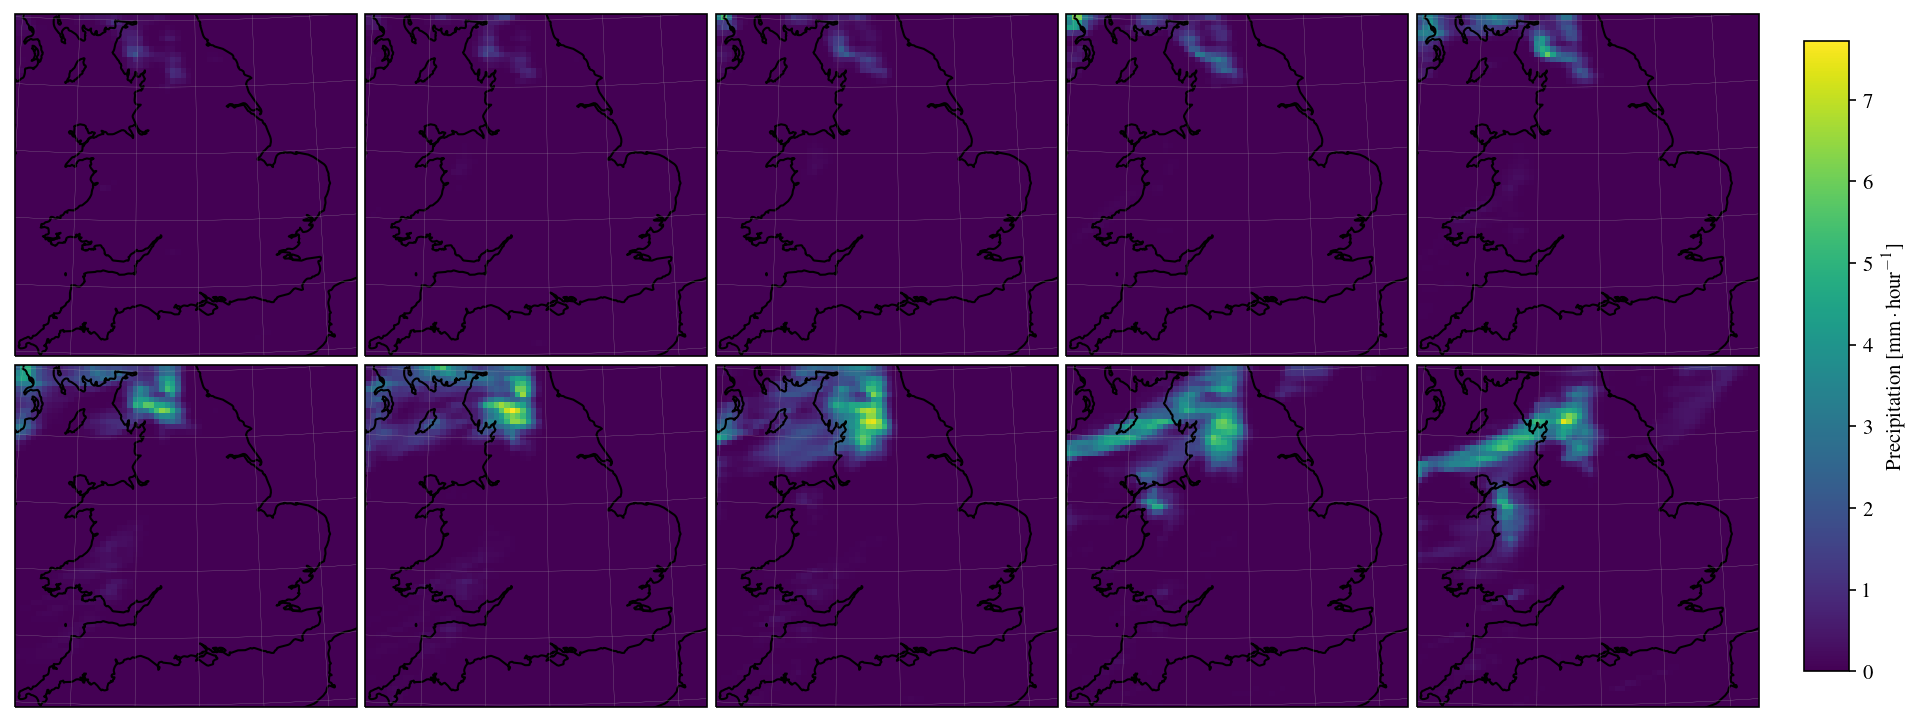

In [121]:
sample = samples[270][0]

latitudes = xr.DataArray(np.load('latitude.npy'), dims = ('y', 'x'))
longitudes = xr.DataArray(np.load('longitude.npy'), dims = ('y', 'x'))
da = xr.DataArray(sample, dims=('time', 'y', 'x'), coords={'latitude': latitudes, 'longitude': longitudes})

cp_model_rotated_pole = ccrs.RotatedPole(pole_longitude=177.5, pole_latitude=37.5)

fig, axes = plt.subplots(
    nrows=2,
    ncols=5,
    figsize=(15, 6),
    subplot_kw={'projection': cp_model_rotated_pole},
    gridspec_kw = {'wspace': 0.025, 'hspace': 0.025}
)
fig.subplots_adjust(right=0.9)
cbar_ax = fig.add_axes([0.92, 0.15, 0.02, 0.7])  # [left, bottom, width, height]

for i, ax in enumerate(axes.flat):
    im = da.isel(time=i).plot(
        ax=ax, 
        x = 'longitude', 
        y = 'latitude',
        vmin = da.min().values,
        vmax = da.max().values,
        transform=ccrs.PlateCarree(),
        add_colorbar = False,
        # cbar_kwargs={'label': 'Precipitation [$\mathrm{mm}\cdot\mathrm{hour}^{-1}$]', 'shrink': 0.7},
    )
    ax.gridlines(linewidth = 0.1)
    ax.coastlines()
    # ax.set_title(f'Hour {i}')

cb = fig.colorbar(im, cax=cbar_ax)
cb.set_label('Precipitation [$\mathrm{mm}\cdot\mathrm{hour}^{-1}$]')

plt.show()